In [24]:
import numpy as np
import matplotlib.pyplot as plt
import openmc
import openmc.data
import openmc.deplete
import openmc.mgxs
from scipy.constants import Avogadro
import radioactivedecay as rd
import Constants


In [25]:
gas = openmc.Material(name="Gas")
gas.add_element("Argon", 1)
gas.set_density("g/cm3", 1)

oxygen = openmc.Material(name = "Oxygen")
oxygen.add_element("oxygen", 1)
oxygen.set_density("g/cm3", 1)

mats = openmc.Materials([gas,oxygen])
mats.export_to_xml(str(Constants.materials_xml_path))

FileNotFoundError: [Errno 2] No such file or directory: '/root/endfb-vii.1-hdf5/cross_sections.xml'

/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=10.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=20.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=30.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=40.
  warn(msg, IDWarning)


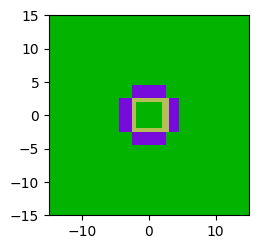

In [ ]:
allCells = []

bot_pose = {"x":0,"y":0}
bot_size = {"Length":3,"Width":3}
geiger_tube_radius = 2

cyl_1 = openmc.XCylinder(y0=bot_pose["y"]-(bot_size["Width"]+geiger_tube_radius*2)/2,z0=0,r = geiger_tube_radius,boundary_type = "transmission")
cyl_2 = openmc.YCylinder(x0=bot_pose["x"]-(bot_size["Length"]+geiger_tube_radius*2)/2,z0=0,r = geiger_tube_radius,boundary_type = "transmission")
cyl_3 = openmc.XCylinder(y0=bot_pose["y"]+(bot_size["Width"]+geiger_tube_radius*2)/2,z0=0,r = geiger_tube_radius,boundary_type = "transmission")
cyl_4 = openmc.YCylinder(x0=bot_pose["x"]+(bot_size["Length"]+geiger_tube_radius*2)/2,z0=0,r = geiger_tube_radius,boundary_type = "transmission")        

plane_1 = openmc.XPlane(x0 = bot_pose["x"]-(bot_size["Length"])/2)
plane_2 = openmc.XPlane(x0 = bot_pose["x"]+(bot_size["Length"])/2)
plane_3 = openmc.YPlane(y0 = bot_pose["y"]-(bot_size["Width"])/2)
plane_4 = openmc.YPlane(y0 = bot_pose["y"]+(bot_size["Width"])/2)

ray_blocker_1 = openmc.rectangular_prism(axis = "z", width = bot_size["Length"], height = 1, origin = (bot_pose["x"],bot_pose["y"]-bot_size["Width"]/2),boundary_type="vacuum")
ray_blocker_2 = openmc.rectangular_prism(axis = "z", width = 1, height = bot_size["Width"], origin = (bot_pose["x"]-bot_size["Length"]/2,bot_pose["y"]),boundary_type="vacuum")
ray_blocker_3 = openmc.rectangular_prism(axis = "z", width = bot_size["Length"], height = 1, origin = (bot_pose["x"],bot_pose["y"]+bot_size["Width"]/2),boundary_type="vacuum")
ray_blocker_4 = openmc.rectangular_prism(axis = "z", width = 1, height = bot_size["Width"], origin = (bot_pose["x"]+bot_size["Length"]/2,bot_pose["y"]),boundary_type="vacuum")

cell_1 = openmc.Cell(cell_id = 10)
cell_1.region = -cyl_1 & +plane_1 & -plane_2
cell_1.fill = gas

cell_2 = openmc.Cell(cell_id = 20)
cell_2.region = -cyl_2 & +plane_3 & -plane_4
cell_2.fill = gas

cell_3 = openmc.Cell(cell_id = 30)
cell_3.region = -cyl_3 & +plane_1 & -plane_2
cell_3.fill = gas

cell_4 = openmc.Cell(cell_id = 40)
cell_4.region = -cyl_4 & +plane_3 & -plane_4
cell_4.fill = gas

allCells.append(cell_1)
allCells.append(cell_2)
allCells.append(cell_3)
allCells.append(cell_4)

blocker_cell_1 = openmc.Cell(region=ray_blocker_1)
blocker_cell_2 = openmc.Cell(region=ray_blocker_2)
blocker_cell_3 = openmc.Cell(region=ray_blocker_3)
blocker_cell_4 = openmc.Cell(region=ray_blocker_4)

outer_surface = openmc.Sphere(r=150.0)
outer_surface.boundary_type = 'vacuum'

inner_surface = openmc.Sphere(r=140.0)
inner_surface.boundary_type = 'vacuum'

empty_space = openmc.Cell()
empty_space.region = -inner_surface & ~(-cyl_1 & +plane_1 & -plane_2) & ~(-cyl_2 & +plane_3 & -plane_4) & ~(-cyl_3 & +plane_1 & -plane_2) & ~(-cyl_4 & +plane_3 & -plane_4)
empty_space.fill = oxygen

universe = openmc.Universe(cells=[cell_1,cell_2, cell_3, cell_4,
                                        empty_space,
                                        blocker_cell_1,blocker_cell_2,blocker_cell_3,blocker_cell_4])
geometry = openmc.Geometry(universe)
geometry.export_to_xml(str(Constants.geometry_xml_path))
universe.plot(width=(30.0, 30.0), origin=(0.0, 0.0, 0.0), basis='xy', color_by='material')

In [ ]:
openmc.config['chain_file'] = "/root/openmc-notebooks/load.xml"

half_life_Cs137_seconds = 30.17 * 365 * 24 * 60 * 60
# half_life_Ba137_m1_seconds = 2.55 * 60
half_life_Ba137_m1_seconds = 2.55
Rn222_t0 = rd.Inventory({'Rn-222':2.0},'Bq')
Rn222_t1 = Rn222_t0.decay(20.0,'h')

branching_ratio = 0.946
fraction_atoms_Ba137_m1 = (half_life_Ba137_m1_seconds * branching_ratio) / half_life_Cs137_seconds

number_atoms_Ba137_m1 = (1/10) * Avogadro * fraction_atoms_Ba137_m1
number_atoms_Cs137 = (1/137) * Avogadro * (1-fraction_atoms_Ba137_m1)
radon_source = openmc.Source()
radon_source.space = openmc.stats.Point((-1.0, 0.0, 0.0))
radon_source.angle = openmc.stats.Isotropic()
radon_source.energy = openmc.data.decay_photon_energy("Rn222")
radon_source.particle = 'photon'
radon_source.strength = 1000000000000000


In [ ]:
settings = openmc.Settings()
settings.particles = 10**4
settings.batches = 20
settings.photon_transport = True
settings.source = [radon_source]
settings.run_mode = 'fixed source'
settings.export_to_xml()

In [ ]:
tallies = openmc.Tallies()

energy_bins = np.linspace(0, 1e6, 1001)
energy_filter = openmc.EnergyFilter(energy_bins)
cell_filter = openmc.CellFilter(gass_cell)
particle_filter = openmc.ParticleFilter("photon")

pulse_tally = openmc.Tally(name='pulse-height')
pulse_tally.filters = [cell_filter, energy_filter]
pulse_tally.scores = ['pulse-height']

absorption_tally = openmc.Tally(name="gamma_absorption")
absorption_tally.filters = [cell_filter,particle_filter]
absorption_tally.scores = ["absorption"]

tallies.append(pulse_tally)
tallies.append(absorption_tally)
tallies.export_to_xml()

In [ ]:
# with openmc.StatePoint('summary.h5') as sp:
#     k_eff = sp.keff
openmc.run("/home/cpf/Desktop/openmc/build/bin/openmc")

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [ ]:
sp = openmc.StatePoint('statepoint.20.h5')
tally = sp.get_tally(name='pulse-height')
pulse_height_values = tally.get_values(scores=['pulse-height']).flatten()

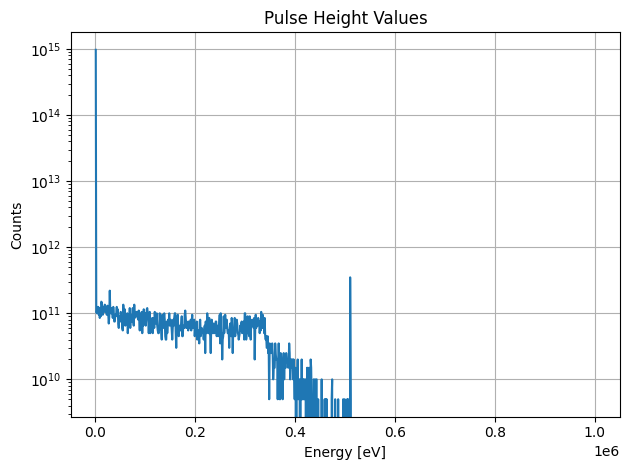

In [ ]:
energy_bin_centers = energy_bins[1:] + 0.5 * (energy_bins[1] - energy_bins[0])

plt.figure()
plt.semilogy(energy_bin_centers, pulse_height_values)

# plot the strongest sources as vertical lines
# plt.axvline(x=800_000, color="red", ls=":")     # source_1
# plt.axvline(x=661_700, color="red", ls=":")     # source_2

plt.xlabel('Energy [eV]')
plt.ylabel('Counts')
plt.title('Pulse Height Values')
plt.grid(True)
plt.tight_layout()
plt.savefig("PH_2")